## Universidade Estadual de Campinas 
## Instituto de Computação
# Imparcialidade
## MO810/MC959 - Tópicos em Inteligência Artificial
## Ética em Aprendizado de Máquina
### Prof. Marcos M. Raimundo
---
### Alunos:
#### Mateus Trentini RA 217290
#### Mauricio Pereira Lopes RA 225242
#### Rita Braga RA 251627
---

In [1]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import StandardDataset
from aif360 import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [2]:
# load datasets

df_train = pd.read_excel("../data/processed/train_data.xlsx")
df_val = pd.read_excel("../data/processed/validation_data.xlsx")
df_test = pd.read_excel("../data/processed/test_data.xlsx")
df_train.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,27623,27623,50000,2,1,2,23,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
1,28377,28377,50000,2,2,1,36,2,2,2,...,47956,43578,35126,0,4700,0,2004,3500,0,0
2,10918,10918,200000,2,3,1,54,6,5,4,...,102549,101400,0,0,0,0,0,0,0,0
3,27235,27235,240000,1,1,1,35,-1,-1,-1,...,17102,13367,22659,2017,21817,1120,13434,22772,22820,0
4,15172,15172,60000,2,1,2,23,0,0,0,...,8549,7635,12258,3126,1392,5033,3601,5200,3647,0


---
# Enuncie e apresente uma ou mais métricas de imparcialidade mais ajustadas à aplicação escolhida, justifique.

---
## Measuring Fairness Using Equal Opportunity

In [3]:
# load trained models

lda_model = pickle.load(open('../models/best_lda.pkl', 'rb'))
logreg_model = pickle.load(open('../models/best_logreg.pkl', 'rb'))
dt_model = pickle.load(open('../models/best_decision_tree.pkl', 'rb'))
rf_model = pickle.load(open('../models/best_rf.pkl', 'rb'))

In [4]:
# predict on validation dataset
X_val = df_val.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])

# LDA model's prediction
y_hat_lda = lda_model.predict(X_val)

# Logistic Regression model's prediction
y_hat_logreg_model = logreg_model.predict(X_val)

# Decision Tree model's prediction
y_hat_dt = dt_model.predict(X_val)

# Random Forest model's prediction
y_hat_rf = rf_model.predict(X_val)

In [5]:
# create new datafrane with sensitive attributes, predictions for each model and ground truth
y_hat_vs_y_val = pd.DataFrame({'SEX': df_val.SEX, 'MARRIAGE': df_val.MARRIAGE, 'AGE': df_val.AGE, 'EDUCATION': df_val.EDUCATION,
                               'y_hat_lda': y_hat_lda, 'y_hat_logreg': y_hat_logreg_model,
                               'y_hat_dt': y_hat_dt, 'y_hat_rf': y_hat_rf, 'y_val': df_val['default payment next month']})

In [6]:
# Separate data by sex
male = y_hat_vs_y_val[y_hat_vs_y_val['SEX'] == 1]
female = y_hat_vs_y_val[y_hat_vs_y_val['SEX'] == 2]

# Separate data by marriage
married = y_hat_vs_y_val[y_hat_vs_y_val['MARRIAGE'] == 1]
single = y_hat_vs_y_val[y_hat_vs_y_val['MARRIAGE'] == 2]
olther = y_hat_vs_y_val[y_hat_vs_y_val['MARRIAGE'] == 3]

# Separate data by age
above_25 = y_hat_vs_y_val[y_hat_vs_y_val['AGE'] > 25]
below_or_equal_25 = y_hat_vs_y_val[y_hat_vs_y_val['AGE'] <= 25]

# Separate data by education
graduate = y_hat_vs_y_val[y_hat_vs_y_val['EDUCATION'] == 1]
university = y_hat_vs_y_val[y_hat_vs_y_val['EDUCATION'] == 2]
high_school = y_hat_vs_y_val[y_hat_vs_y_val['EDUCATION'] == 3]
olther = y_hat_vs_y_val[y_hat_vs_y_val['EDUCATION'] == 4]

Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.621
Female: 0.667
Difference: -0.046

False Negative Rates:
Male: 0.379
Female: 0.333
Difference: 0.046


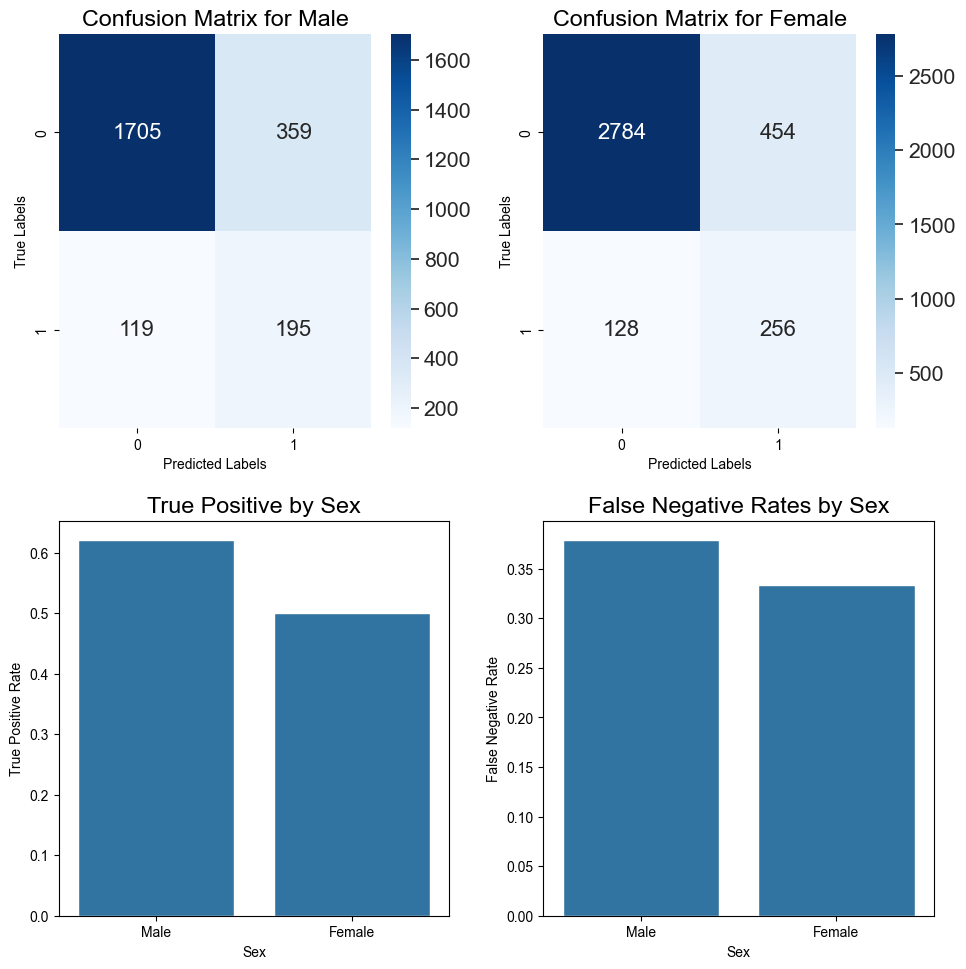

In [7]:
# Random Forest model

# Calculate confusion matrices for each group
male_matrix = confusion_matrix(male.y_hat_rf, male.y_val)
female_matrix = confusion_matrix(female.y_hat_rf, female.y_val)

# Calculate true positive rates for each group
male_tpr = male_matrix[1,1] / (male_matrix[1,0] + male_matrix[1,1])
female_tpr = female_matrix[1,1] / (female_matrix[1,0] + female_matrix[1,1])

# Compare true positive rates to assess fairness
if male_tpr == female_tpr:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")


# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))

# Plot confusion matrices
sns.set(font_scale=1.4)
sns.heatmap(male_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', ax=ax1)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix for Male')

sns.set(font_scale=1.4)
sns.heatmap(female_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', ax=ax2)
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_title('Confusion Matrix for Female')

# Create bar chart
tpr = [male_matrix[1,1] / (male_matrix[1,1] + male_matrix[1,0]),
       female_matrix[1,1] / (female_matrix[1,1] + female_matrix[1,1])]
sex = ['Male', 'Female']
sns.barplot(x=sex, y=tpr, ax=ax3)
ax3.set_xlabel('Sex')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('True Positive by Sex')


# Create bar chart
male_fnr = male_matrix[1,0] / (male_matrix[1,0] + male_matrix[1,1])
female_fnr = female_matrix[1,0] / (female_matrix[1,0] + female_matrix[1,1])
fnr = [male_fnr, female_fnr]
sex = ['Male', 'Female']
sns.barplot(x=sex, y=fnr, ax=ax4)
ax4.set_xlabel('Sex')
ax4.set_ylabel('False Negative Rate')
ax4.set_title('False Negative Rates by Sex')

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Difference: {:.3f}'.format(male_tpr - female_tpr))

# Output false negative rates
print("\nFalse Negative Rates:")
print("Male: {:.3f}".format(male_fnr))
print("Female: {:.3f}".format(female_fnr))
print('Difference: {:.3f}'.format(male_fnr - female_fnr))

plt.tight_layout()
plt.show()

---
## Measuring Fairness Using Equalized Odds


True Positive Rates:
Male: 0.621
Female: 0.667
Difference: -0.046

False Negative Rates:
Male: 0.174
Female: 0.140
Difference: 0.034


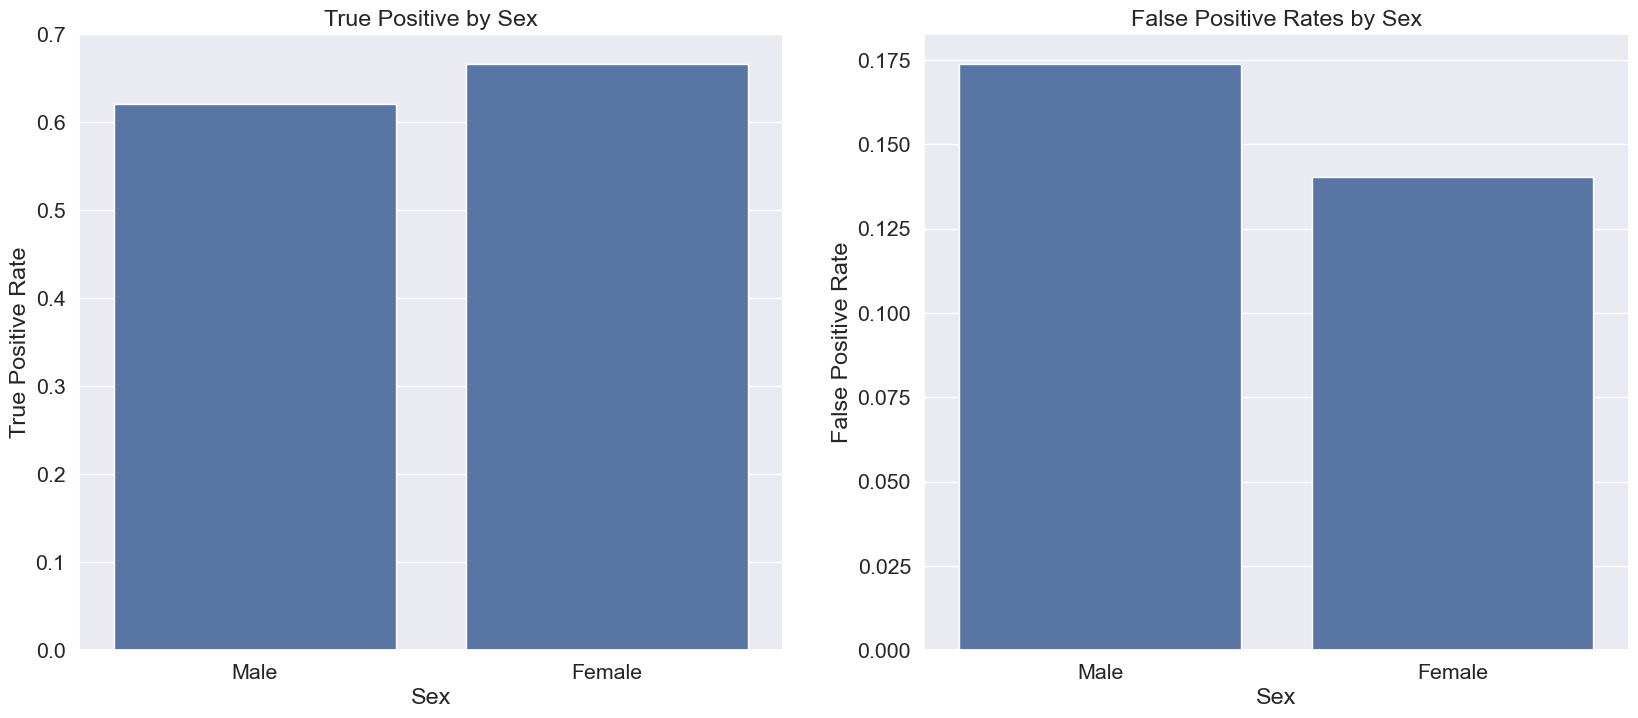

In [8]:
# Calculate true positive rates for each group
male_tpr = male_matrix[1,1] / (male_matrix[1,0] + male_matrix[1,1])
female_tpr = female_matrix[1,1] / (female_matrix[1,0] + female_matrix[1,1])

# Calculate false positive rates for each group
male_fpr = male_matrix[0,1] / (male_matrix[0,1] + male_matrix[0,0])
female_fpr = female_matrix[0,1] / (female_matrix[0,1] + female_matrix[0,0])


# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Difference: {:.3f}'.format(male_tpr - female_tpr))


# Output false positive rates
print("\nFalse Negative Rates:")
print("Male: {:.3f}".format(male_fpr))
print("Female: {:.3f}".format(female_fpr))
print('Difference: {:.3f}'.format(male_fpr - female_fpr))


# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize=(20,8))

# Create bar chart
tpr = [male_tpr, female_tpr]
sex = ['Male', 'Female']
sns.barplot(x=sex, y=tpr, ax=ax1)
ax1.set_xlabel('Sex')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('True Positive by Sex')


# Create bar chart
fpr = [male_fpr, female_fpr]
sex = ['Male', 'Female']
sns.barplot(x=sex, y=fpr, ax=ax2)
ax2.set_xlabel('Sex')
ax2.set_ylabel('False Positive Rate')
ax2.set_title('False Positive Rates by Sex')

plt.show()

---
## Disparate impact

Percentage Predicted as Positive:
Male: 23.297
Female: 19.602
Disparate impact: 3.694


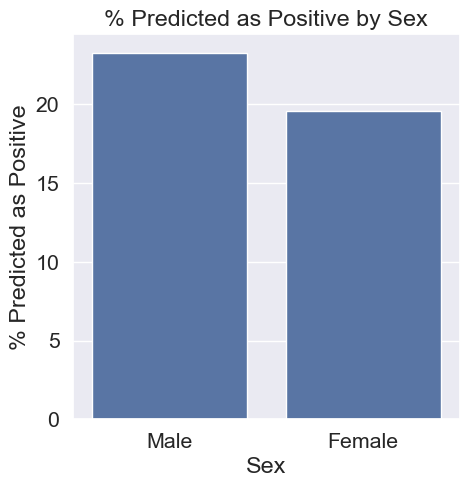

In [9]:
male_ppp = 100 * (male_matrix[1,1] + male_matrix[0,1]) / male_matrix.sum()
female_ppp = 100 * (female_matrix[1,1] + female_matrix[0,1]) / female_matrix.sum()

# Output
print("Percentage Predicted as Positive:")
print("Male: {:.3f}".format(male_ppp))
print("Female: {:.3f}".format(female_ppp))
print('Disparate impact: {:.3f}'.format(male_ppp - female_ppp))

# Create subplots
fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(5,5))

# Create bar chart
tpr = [male_ppp, female_ppp]
sex = ['Male', 'Female']
sns.barplot(x = sex, y = tpr, ax=ax1)
ax1.set_xlabel('Sex')
ax1.set_ylabel('% Predicted as Positive')
ax1.set_title('% Predicted as Positive by Sex')

plt.show()

---
# Aplique duas metodologias de pré-processamento mais adequadas à aplicação escolhida.
---

## Reweighing

In [11]:
# define sensitive / protected attribute
protected_attribute = ['SEX']
df_train['SEX'] = df_train['SEX'].map(str)

# define privileged and unprivileged groups
privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 0}]

# convert train set to AIF360 dataset
aif360_train_data = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

# Apply Reweighing algorithm
reweighing = Reweighing(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
transformed_data_train = reweighing.fit_transform(aif360_train_data)

# Retrieve the transformed data
X_train_transformed = transformed_data_train.features
y_train_transformed = transformed_data_train.labels.ravel()

# Train Random Forest classifier on the transformed dataset
classifier = RandomForestClassifier(random_state = 42)
classifier.fit(X_train_transformed, y_train_transformed)

# convert validation set to AIF360 dataset
df_val['SEX'] = df_val['SEX'].map(str)

aif360_val_data = StandardDataset(df_val, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

# Apply the same transformation on the validation set
transformed_data_val = reweighing.fit_transform(aif360_val_data)

# Retrieve the transformed test set
X_val_transformed = transformed_data_val.features
y_val_transformed = transformed_data_val.labels.ravel()

# make predictions
predictions = classifier.predict(X_val_transformed)

# using predicted values to measure bias in the validation dataset

dataset_pred_val = aif360_val_data.copy()
dataset_pred_val.labels = predictions


metric_orig_val = BinaryLabelDatasetMetric(aif360_val_data, 
                                           unprivileged_groups = unprivileged_groups,
                                           privileged_groups = privileged_groups)


classified_metric_val = ClassificationMetric(aif360_val_data, 
                                             dataset_pred_val,
                                             unprivileged_groups=unprivileged_groups, 
                                             privileged_groups=privileged_groups)

print('\nValidation dataset')
print("statistical_parity_difference = %f" % metric_orig_val.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_val.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_val.equal_opportunity_difference())


Validation dataset
statistical_parity_difference = 0.036945
disparate impact = 1.048166
equal opportunity difference = 0.024563


---
## Disparate Impact Remover


In [ ]:
# define sensitive / protected attribute
protected_attribute = ['SEX']
df_train['SEX'] = df_train['SEX'].map(str)

# define privileged and unprivileged groups
privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 0}]

# convert train set to AIF360 dataset
aif360_train_data = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

# Apply DisparateImpactRemover algorithm
di_reducer = DisparateImpactRemover(repair_level = 1.0)
transformed_data_train = di_reducer.fit_transform(aif360_train_data)

# Retrieve the transformed data
X_train_transformed = transformed_data_train.features
y_train_transformed = transformed_data_train.labels.ravel()

# Train Random Forest classifier on the transformed dataset
classifier = RandomForestClassifier(random_state = 42)
classifier.fit(X_train_transformed, y_train_transformed)

# convert validation set to AIF360 dataset
df_val['SEX'] = df_val['SEX'].map(str)

aif360_val_data = StandardDataset(df_val, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

# Apply the same transformation on the validation set
transformed_data_val = di_reducer.fit_transform(aif360_val_data)

# Retrieve the transformed test set
X_val_transformed = transformed_data_val.features
y_val_transformed = transformed_data_val.labels.ravel()

# make predictions
predictions = classifier.predict(X_val_transformed)

# using predicted values to measure bias in the validation dataset

dataset_pred_val = aif360_val_data.copy()
dataset_pred_val.labels = predictions


metric_orig_val = BinaryLabelDatasetMetric(aif360_val_data, 
                                           unprivileged_groups = unprivileged_groups,
                                           privileged_groups = privileged_groups)


classified_metric_val = ClassificationMetric(aif360_val_data, 
                                             dataset_pred_val,
                                             unprivileged_groups=unprivileged_groups, 
                                             privileged_groups=privileged_groups)

print('\nValidation dataset')
print("statistical_parity_difference = %f" % metric_orig_val.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_val.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_val.equal_opportunity_difference())

---
# Aplique duas metodologias de processamento mais adequadas à aplicação escolhida.
---

## Adversarial Fairness Classifier

In [34]:
from fairlearn.adversarial import AdversarialFairnessClassifier

mitigator = AdversarialFairnessClassifier(
    backend = "torch",
    predictor_model = [50, "leaky_relu"],
    adversary_model = [3, "leaky_relu"],
    batch_size = 2 ** 8,
    progress_updates = 0.5,
    random_state = 42)

In [35]:
df_train = df_train.drop(['Unnamed: 0', 'ID'], axis = 1)
columns = df_train.columns.to_list()
columns_types = ['int', 'category', 'category', 'category', 'int',
                 'category', 'category', 'category', 'category', 'category', 'category',
                 'int', 'int', 'int', 'int', 'int', 'int',
                 'int', 'int', 'int', 'int', 'int', 'int', 'category']

for i in list(range(len(columns))):
    df_train[columns[i]] = df_train[columns[i]].astype(columns_types[i])

In [55]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

ct = make_column_transformer((Pipeline([("imputer", SimpleImputer(strategy = "mean")),
                                        ("normalizer", StandardScaler())]),
                              make_column_selector(dtype_include = 'int64')),
                             (Pipeline([("imputer", SimpleImputer(strategy = "most_frequent")),
                                        ("encoder", OneHotEncoder(drop = "if_binary", sparse_output = False))]),
                              make_column_selector(dtype_include = "category")))

In [56]:
X_train = df_train.drop(columns=['default payment next month'])
X_prep_train = ct.fit_transform(X_train)

In [57]:
# predict on validation dataset
y_train = df_train['default payment next month']
z_train = X_train["SEX"]

mitigator.fit(X_prep_train, y_train, sensitive_features = z_train)

AdversarialFairnessClassifier(adversary_model=[3, 'leaky_relu'],
                              backend='torch', batch_size=256,
                              predictor_model=[50, 'leaky_relu'],
                              progress_updates=0.5, random_state=42)

In [58]:
X_prep_val = ct.transform(X_val)
y_val = df_val['default payment next month']
z_val = X_val.SEX

predictions = mitigator.predict(X_prep_val)

In [59]:
from fairlearn.metrics import (MetricFrame, selection_rate, demographic_parity_difference,
                               equalized_odds_difference)
from sklearn.metrics import accuracy_score

mf = MetricFrame(
    metrics = {"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true = y_val,
    y_pred = predictions,
    sensitive_features = z_val)

/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFram

In [54]:
print(mf.by_group)

     accuracy  selection_rate
SEX                          
1    0.791421        0.100084
2    0.817504        0.121204


---
# Aplique duas metodologias de pós-processamento mais adequadas à aplicação escolhida.
---

## Calibrated Equalized Odds Postprocessing

In [125]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

df_val = pd.read_excel("../data/processed/validation_data.xlsx")

# predict on validation dataset
X_val = df_val.drop(columns=['default payment next month'])

# Predict probabilities on the test set
#y_pred_probs = classifier.predict_proba(X_val)[:, 1]
y_pred = classifier.predict(X_val)

# Apply Calibrated Equalized Odds Postprocessing
calib_eqodds = CalibratedEqOddsPostprocessing(unprivileged_groups, privileged_groups, cost_constraint = 'weighted', seed = 42)

# Create a dataset from the validation data and predictions
df_true = df_val.copy()
df_true['SEX'] = df_true['SEX'].map(str)

df_pred = df_val.copy()
df_pred['default payment next month'] = y_pred
df_pred['SEX'] = df_pred['SEX'].map(str)

aif360_val_data = StandardDataset(df_true, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

aif360_val_data_pred = StandardDataset(df_pred, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

calib_eqodds.fit(aif360_val_data, aif360_val_data_pred)


# Obtain the labels with mitigated bias
y_pred_probs_postprocessed = calib_eqodds.predict(aif360_val_data)

# Assess fairness metrics using AIF360
classified_metric_val = ClassificationMetric(aif360_val_data,
                                         y_pred_probs_postprocessed,
                                         unprivileged_groups = unprivileged_groups,
                                         privileged_groups = privileged_groups)
print("Classification accuracy after mitigation:", classified_metric_val.accuracy())
print('equal opportunity difference = %f' % classified_metric_val.equal_opportunity_difference())

Classification accuracy after mitigation: 0.9755
equal opportunity difference = 0.000000


/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


---
# Daqui pra baixo estão só experimentos e testes que eu não quis apagar por enquanto, mas nada deu certo.

## Prejudice Remover

In [ ]:
# convert train set to AIF360 dataset
aif360_train_data = BinaryLabelDataset(favorable_label = 1,
                                       unfavorable_label = 0,
                                       df = df_train,
                                       label_names = ['default payment next month'],
                                       protected_attribute_names = ['SEX'],
                                       unprivileged_protected_attributes = unprivileged_groups)

In [ ]:
# Apply Prejudice Remover during model training
pr_model = PrejudiceRemover(sensitive_attr = 'SEX')
pr_model.fit(aif360_train_data)

# Train a classifier on the transformed dataset
X_train_transformed = aif360_train_data.features

# Get predictions on the transformed training data
predictions_train = pr_model.predict(X_train_transformed)

classifier.fit(X_train_transformed, predictions_train.labels.ravel())

# convert validation set to AIF360 dataset
aif360_val_data = BinaryLabelDataset(favorable_label = 1,
                                       unfavorable_label = 0,
                                       df = df_val,
                                       label_names = ['default payment next month'],
                                       protected_attribute_names = ['SEX'],
                                       unprivileged_protected_attributes = unprivileged_groups)

# Get predictions on the transformed validation data
predictions_val = pr_model.predict(aif360_val_data)

# Evaluate the classifier on the transformed validation set
X_val_transformed = aif360_val_data.features

classifier_predictions = classifier.predict(X_val_transformed)

# Assess fairness metrics using AIF360
classified_metric = ClassificationMetric(aif360_val_data,
                                         predictions_val,
                                         unprivileged_groups = unprivileged_groups,
                                         privileged_groups = privileged_groups)
print("Classification accuracy:", classified_metric.accuracy())

In [ ]:


# Retrieve the transformed data
X_train_transformed = transformed_data_train.features
y_train_transformed = transformed_data_train.labels.ravel()

# Train Random Forest classifier on the transformed dataset
classifier = RandomForestClassifier(random_state = 42)
classifier.fit(X_train_transformed, y_train_transformed)

# convert validation set to AIF360 dataset
df_val['SEX'] = df_val['SEX'].map(str)

aif360_val_data = StandardDataset(df_val, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

# Apply the same transformation on the validation set
transformed_data_val = di_reducer.fit_transform(aif360_val_data)

# Retrieve the transformed test set
X_val_transformed = transformed_data_val.features
y_val_transformed = transformed_data_val.labels.ravel()

# make predictions
predictions = classifier.predict(X_val_transformed)

# using predicted values to measure bias in the validation dataset

dataset_pred_val = aif360_val_data.copy()
dataset_pred_val.labels = predictions


metric_orig_val = BinaryLabelDatasetMetric(aif360_val_data, 
                                           unprivileged_groups = unprivileged_groups,
                                           privileged_groups = privileged_groups)


classified_metric_val = ClassificationMetric(aif360_val_data, 
                                             dataset_pred_val,
                                             unprivileged_groups=unprivileged_groups, 
                                             privileged_groups=privileged_groups)

print('\nValidation dataset')
print("statistical_parity_difference = %f" % metric_orig_val.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_val.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_val.equal_opportunity_difference())

In [ ]:
X_train = df_train.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])

In [ ]:
# Convert data to AIF360's BinaryLabelDataset format
train_data = pd.DataFrame(data=X_train, columns=['feature1', 'feature2', ...])  # Replace columns with your feature names
train_data[protected_attribute] = train_data[protected_attribute].astype(np.float64)
train_data['label'] = y_train.astype(np.float64)

In [ ]:
# Convert to AIF360 dataset format
aif360_train_data = BinaryLabelDataset(favorable_label = 1,
                                       unfavorable_label = 0,
                                       df = df_train,
                                       label_names = ['default payment next month'],
                                       protected_attribute_names = [protected_attribute],
                                       unprivileged_protected_attributes = unprivileged_groups)


In [ ]:
# Apply Reweighing algorithm
reweighing = Reweighing(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
transformed_data_train = reweighing.fit_transform(aif360_train_data)

In [ ]:
# Retrieve the transformed data
X_train_transformed = transformed_data_train.features
y_train_transformed = transformed_data_train.labels.ravel()

In [ ]:
# Train Random Forest classifier on the transformed dataset
scaler = StandardScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)  # Scale features if necessary

classifier = RandomForestClassifier(random_state = 42)
classifier.fit(X_train_transformed_scaled, y_train_transformed)

In [ ]:
# Evaluate on the validation set (perform similar transformations as done on the training set)

# Convert validation data to AIF360's BinaryLabelDataset format
aif360_val_data = BinaryLabelDataset(favorable_label = 1,
                                      unfavorable_label = 0,
                                      df = df_val,
                                      label_names = ['default payment next month'],
                                      protected_attribute_names = [protected_attribute],
                                      unprivileged_protected_attributes = unprivileged_groups)

# Apply the same transformation on the validation set
transformed_data_val = reweighing.fit_transform(aif360_val_data)

# Retrieve the transformed test set
X_val_transformed = transformed_data_val.features
y_val_transformed = transformed_data_val.labels.ravel()

# Evaluate the classifier on the transformed test set
X_val_transformed_scaled = scaler.transform(X_val_transformed)  # Scale test features if necessary

predictions = classifier.predict(X_val_transformed_scaled)

# Convert predictions to a BinaryLabelDataset format
predictions_data = pd.DataFrame({'SEX': X_val['SEX'], 'default payment next month': predictions})
aif360_predictions = BinaryLabelDataset(favorable_label = 1,
                                        unfavorable_label = 0,
                                        df = predictions_data,
                                        label_names = ['default payment next month'],
                                        protected_attribute_names = [protected_attribute],
                                        unprivileged_protected_attributes = unprivileged_groups)
                                 

# Assess fairness metrics using AIF360
classified_metric = ClassificationMetric(aif360_val_data,
                                         aif360_predictions,
                                         unprivileged_groups = unprivileged_groups,
                                         privileged_groups = privileged_groups)
print("Classification accuracy:", classified_metric.accuracy())
print("Disparate impact:", classified_metric.disparate_impact())

In [ ]:
X_val['SEX']

In [ ]:
# load trained models

lda_model = pickle.load(open('../models/best_lda.pkl', 'rb'))
logreg_model = pickle.load(open('../models/best_logreg.pkl', 'rb'))
dt_model = pickle.load(open('../models/best_decision_tree.pkl', 'rb'))
rf_model = pickle.load(open('../models/best_rf.pkl', 'rb'))

In [ ]:
# check if SEX is a biased attribute

# define sensitive / protected attribute
protected_attribute = ['SEX']
df_train['SEX'] = df_train['SEX'].map(str)

# define privileged and unprivileged groups
privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 0}]

# using ground truth to measure bias in the training dataset
y_train = df_train['default payment next month']

dataset = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

dataset_pred = dataset.copy()
dataset_pred.labels = y_train

metric_orig = BinaryLabelDatasetMetric(dataset, 
                                       unprivileged_groups = unprivileged_groups,
                                       privileged_groups = privileged_groups)

classified_metric = ClassificationMetric(dataset, 
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups)

print('\nOriginal dataset')
print("statistical_parity_difference = %f" % metric_orig.statistical_parity_difference())
print("disparate impact = %f" % metric_orig.disparate_impact())
print('equal opportunity difference = %f' % classified_metric.equal_opportunity_difference())


# using predicted values to measure bias in the training dataset

X_train = df_train.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
y_hat_train = rf_model.predict(X_train)

dataset_train = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes = [['1']])

dataset_pred_train = dataset_train.copy()
dataset_pred_train.labels = y_hat_train

metric_orig_train = BinaryLabelDatasetMetric(dataset_train, 
                                             unprivileged_groups = unprivileged_groups,
                                             privileged_groups = privileged_groups)

classified_metric_train = ClassificationMetric(dataset_train, 
                                               dataset_pred_train,
                                               unprivileged_groups=unprivileged_groups, 
                                               privileged_groups=privileged_groups)

print('\nTraining dataset')
print("statistical_parity_difference = %f" % metric_orig_train.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_train.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_train.equal_opportunity_difference())


# using predicted values to measure bias in the validation dataset

X_val = df_val.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
y_hat_val = rf_model.predict(X_val)

df_val['SEX'] = df_val['SEX'].map(str)

dataset_val = StandardDataset(df_val, 
                              label_name = 'default payment next month', 
                              favorable_classes = [0],
                              protected_attribute_names = protected_attribute,
                              privileged_classes = [['1']])

dataset_pred_val = dataset_val.copy()
dataset_pred_val.labels = y_hat_val


metric_orig_val = BinaryLabelDatasetMetric(dataset_val, 
                                           unprivileged_groups = unprivileged_groups,
                                           privileged_groups = privileged_groups)


classified_metric_val = ClassificationMetric(dataset_val, 
                                             dataset_pred_val,
                                             unprivileged_groups=unprivileged_groups, 
                                             privileged_groups=privileged_groups)

print('\nValidation dataset')
print("statistical_parity_difference = %f" % metric_orig_val.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_val.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_val.equal_opportunity_difference())


# using predicted values to measure bias in the test dataset

X_test = df_test.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
y_hat_test = rf_model.predict(X_test)

df_test['SEX'] = df_test['SEX'].map(str)

dataset_test = StandardDataset(df_test, 
                               label_name = 'default payment next month', 
                               favorable_classes = [0],
                               protected_attribute_names = protected_attribute,
                               privileged_classes = [['1']])

dataset_pred_test = dataset_test.copy()
dataset_pred_test.labels = y_hat_test


metric_orig_test = BinaryLabelDatasetMetric(dataset_test, 
                                            unprivileged_groups = unprivileged_groups,
                                            privileged_groups = privileged_groups)


classified_metric_test = ClassificationMetric(dataset_test, 
                                              dataset_pred_test,
                                              unprivileged_groups=unprivileged_groups, 
                                              privileged_groups=privileged_groups)

print('\nTest dataset')
print("statistical_parity_difference = %f" % metric_orig_test.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_test.disparate_impact())
print('equal opportunity difference = %f' % classified_metric_test.equal_opportunity_difference())

In [ ]:
# check if AGE is a biased attribute

# define sensitive / protected attribute
protected_attribute = ['AGE']

# define privileged and unprivileged groups
privileged_groups = [{'AGE': 1}]
unprivileged_groups = [{'AGE': 0}]

aif_ds = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes=[lambda x: x >= 25])

metric_orig_train = BinaryLabelDatasetMetric(aif_ds, 
                                             unprivileged_groups = unprivileged_groups,
                                             privileged_groups = privileged_groups)


dataset_pred = aif_ds.copy()
dataset_pred.labels = df_train['default payment next month']

classified_metric = ClassificationMetric(aif_ds, 
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups)

print('Original training dataset')
print("statistical_parity_difference = %f" % metric_orig_train.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_train.disparate_impact())
print('equal opportunity difference = %f' % classified_metric.equal_opportunity_difference())

In [ ]:
# check if EDUCATION is a biased attribute

# define sensitive / protected attribute
protected_attribute = ['EDUCATION']
df_train['EDUCATION'] = df_train['EDUCATION'].map(str)

# define privileged and unprivileged groups
privileged_groups = [{'EDUCATION': 1}]
unprivileged_groups = [{'EDUCATION': 0}]

aif_ds = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes=[['1', '2']])

metric_orig_train = BinaryLabelDatasetMetric(aif_ds, 
                                             unprivileged_groups = unprivileged_groups,
                                             privileged_groups = privileged_groups)


dataset_pred = aif_ds.copy()
dataset_pred.labels = df_train['default payment next month']

classified_metric = ClassificationMetric(aif_ds, 
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups)

print('Original training dataset')
print("statistical_parity_difference = %f" % metric_orig_train.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_train.disparate_impact())
print('equal opportunity difference = %f' % classified_metric.equal_opportunity_difference())

In [ ]:
# check if MARRIAGE is a biased attribute
'''
MARRIAGE	Category	1 = married; 2 = single; 3 = others
'''

# define sensitive / protected attribute
protected_attribute = ['MARRIAGE']
df_train['MARRIAGE'] = df_train['MARRIAGE'].map(str)

# define privileged and unprivileged groups
privileged_groups = [{'MARRIAGE': 1}]
unprivileged_groups = [{'MARRIAGE': 0}]

aif_ds = StandardDataset(df_train, 
                         label_name = 'default payment next month', 
                         favorable_classes = [0],
                         protected_attribute_names = protected_attribute,
                         privileged_classes=[['1']])

metric_orig_train = BinaryLabelDatasetMetric(aif_ds, 
                                             unprivileged_groups = unprivileged_groups,
                                             privileged_groups = privileged_groups)

dataset_pred = aif_ds.copy()
dataset_pred.labels = df_train['default payment next month']

classified_metric = ClassificationMetric(aif_ds, 
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups)

print('Original training dataset')
print("statistical_parity_difference = %f" % metric_orig_train.statistical_parity_difference())
print("disparate impact = %f" % metric_orig_train.disparate_impact())
print('equal opportunity difference = %f' % classified_metric.equal_opportunity_difference())

In [ ]:
df_train['MARRIAGE'].value_counts()

In [ ]:
X = df_test.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
y_hat = lda_model.predict(X)

In [ ]:
X

# Default of credit card clients
This datacard was created in the context of the course **MO810 - Ethics in Machine Learning** at the **Institute of Computing, University of Campinas (UNICAMP)**.

The UCI (University of California, Irvine) Default of Credit Card Clients dataset is a widely used dataset in the field of credit risk analysis and machine learning. It contains information about credit card clients in Taiwan and their repayment behavior. This dataset is often used to build predictive models to assess the likelihood of credit card clients defaulting on their payments.

#### Dataset Link
<!-- info: Provide a link to the dataset: -->
<!-- width: half -->
http://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip

#### Data Card Author(s)
<!-- info: Select **one role per** Data Card Author:

(Usage Note: Select the most appropriate choice to describe the author's role
in creating the Data Card.) -->
<!-- width: half -->
- **Name:** Matheus Trentini - RA 217290
- **Name:** Maurício Pereira Lopes - RA 225242
- **Name:** Rita Braga - RA 251627

## Authorship
### Publishers
#### Publishing Organization(s)
<!-- scope: telescope -->
<!-- info: Provide the names of the institution or organization responsible
for publishing the dataset: -->
UCI (University of California, Irvine)

#### Industry Type(s)
<!-- scope: periscope -->
<!-- info: Select **all applicable** industry types to which the publishing
organizations belong: -->
- Academic - Tech

#### Contact Detail(s)
<!-- scope: microscope -->
<!-- info: Provide publisher contact details: -->
- **Publishing POC:** UCI Machine Learning Repository
- **Contact:** I-Cheng Yeh
- **Website:** http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

### Dataset Owners
#### Team(s)
<!-- scope: telescope -->
<!-- info: Provide the names of the groups or team(s) that own the dataset: -->
UCI (University of California, Irvine)

#### Contact Detail(s)
<!-- scope: periscope -->
<!-- info: Provide pathways to contact dataset owners: -->
- **Dataset Owner(s):** I-Cheng Yeh
- **Affiliation:** UCI (University of California, Irvine)

#### Author(s)
<!-- scope: microscope -->
<!-- info: Provide the details of all authors associated with the dataset:

(Usage Note: Provide the affiliation and year if different from publishing
institutions or multiple affiliations.) -->
- I-Cheng Yeh, 2016

### Funding Sources
#### Institution(s)
<!-- scope: telescope -->
<!-- info: Provide the names of the funding institution(s): -->
- Not available information

#### Funding or Grant Summary(ies)
<!-- scope: periscope -->
<!-- width: full -->
<!-- info: Provide a short summary of programs or projects that may have funded
the creation, collection, or curation of the dataset.

Use additional notes to capture any other relevant information or
considerations. -->

## Dataset Overview
#### Data Subject(s)
<!-- scope: telescope -->
<!-- info: Select ***all applicable**** subjects contained the dataset: -->
- Sensitive Data about people
- Non-Sensitive Data about people

#### Dataset Snapshot
<!-- scope: periscope -->
<!-- info: Provide a snapshot of the dataset:<br><br>(Use the additional notes
to include relevant information, considerations, and links to table(s) with
more detailed breakdowns.) -->
Category | Data
--- | ---
Size of Dataset | 5.539.328 bytes
Number of Instances | 30.000
Number of Fields | 24
Labeled Classes | 2
Number of Labels | 2
Average Labels Per Instance | 123456
Algorithmic Labels | Not available information
Human Labels | Not available information


#### Content Description
<!-- scope: microscope -->
<!-- info: Provide a short description of the content in a data point: -->
The dataset "Default of Credit Card Clients" includes a combination of demographic, financial, and payment history variables that can be used to predict whether a customer will or will not default on their credit card payments. It contains 30 thousand examples (samples) of credit card customers in Taiwan, with 23 independent variables and one that contains binary values (0 or 1) indicating whether a customer has defaulted or not.


#### Descriptive Statistics
<!-- width: full -->
<!-- info: Provide basic descriptive statistics for each field.

Use additional notes to capture any other relevant information or
considerations.

Usage Note: Some statistics will be relevant for numeric data, for not for
strings. -->

|Statistics|   LIMIT_BAL |        AGE |   BILL_AMT1 |   BILL_AMT2 |         BILL_AMT3 |   BILL_AMT4 |   BILL_AMT5 |   BILL_AMT6 |   PAY_AMT1 |        PAY_AMT2 |   PAY_AMT3 |   PAY_AMT4 |   PAY_AMT5 |   PAY_AMT6 |
|:------|------------:|-----------:|------------:|------------:|------------------:|------------:|------------:|------------:|-----------:|----------------:|-----------:|-----------:|-----------:|-----------:|
| count |   30000     | 30000      |    30000    |    30000    |   30000           |    30000    |     30000   |     30000   |   30000    | 30000           |   30000    |   30000    |   30000    |   30000    |
| mean  |  167484     |    35.4855 |    51223.3  |    49179.1  |   47013.2         |    43262.9  |     40311.4 |     38871.8 |    5663.58 |  5921.16        |    5225.68 |    4826.08 |    4799.39 |    5215.5  |
| std   |  129748     |     9.2179 |    73635.9  |    71173.8  |   69349.4         |    64332.9  |     60797.2 |     59554.1 |   16563.3  | 23040.9         |   17607    |   15666.2  |   15278.3  |   17777.5  |
| min   |   10000     |    21      |  -165580    |   -69777    | -157264           |  -170000    |    -81334   |   -339603   |       0    |     0           |       0    |       0    |       0    |       0    |
| 25%   |   50000     |    28      |     3558.75 |     2984.75 |    2666.25        |     2326.75 |      1763   |      1256   |    1000    |   833           |     390    |     296    |     252.5  |     117.75 |
| 50%   |  140000     |    34      |    22381.5  |    21200    |   20088.5         |    19052    |     18104.5 |     17071   |    2100    |  2009           |    1800    |    1500    |    1500    |    1500    |
| 75%   |  240000     |    41      |    67091    |    64006.2  |   60164.8         |    54506    |     50190.5 |     49198.2 |    5006    |  5000           |    4505    |    4013.25 |    4031.5  |    4000    |
| max   |       1e+06 |    79      |   964511    |   983931    |       1.66409e+06 |   891586    |    927171   |    961664   |  873552    |     1.68426e+06 |  896040    |  621000    |  426529    |  528666    |

### Sensitivity of Data
#### Sensitivity Type(s)
<!-- scope: telescope -->
<!-- info: Select ***all applicable*** data types present in the dataset: -->
- User Content
- User Metadata
- Anonymous Data
- Payment Data

#### Field(s) with Sensitive Data
<!-- scope: periscope -->
<!-- info: List fields in the dataset that contain S/PII, and specify if their
collection was intentional or unintentional.

Use additional notes to capture any other relevant information or
considerations. -->
**Intentional Collected Sensitive Data**

There is no personal identifiable information (PII) in the dataset.

Field Name | Description
--- | ---
ID | Anonymized identification
LIMIT_BAL | Sensitive
SEX | Sensitive
EDUCATION | Sensitive
MARRIAGE | Sensitive
AGE | Sensitive
PAY_0 | Sensitive
PAY_2 | Sensitive
PAY_3 | Sensitive
PAY_4 | Sensitive
PAY_5 | Sensitive
PAY_6 | Sensitive
BILL_AMT1 | Sensitive
BILL_AMT2 | Sensitive
BILL_AMT3 | Sensitive
BILL_AMT4 | Sensitive
BILL_AMT5 | Sensitive
BILL_AMT6 | Sensitive
PAY_AMT1 | Sensitive
PAY_AMT2 | Sensitive
PAY_AMT3 | Sensitive
PAY_AMT4 | Sensitive
PAY_AMT5 | Sensitive
PAY_AMT6 | Sensitive
default payment next month | Sensitive


**Unintentionally Collected Sensitive Data**

There is no indication that ant of the information in this database is unintentionally collected data.

#### Security and Privacy Handling
<!-- scope: microscope -->
<!-- info: Summarize the measures or steps to handle sensitive data in this
dataset.

Use additional notes to capture any other relevant information or
considerations. -->

This dataset is publicly published in the Internet under CC BY 4.0 license and there is no PII data. It is not required any additional method for security and privacy handling.


#### Risk Type(s)
<!-- scope: telescope -->
<!-- info: Select **all applicable** risk types presenting from the
dataset: -->
- No Known Risks

#### Supplemental Link(s)
<!-- scope: periscope -->
<!-- info: Provide link(s) for documentation pertaining to sensitive data in
the dataset: -->
**UCI Machine Learning Repository:** http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

#### Risk(s) and Mitigation(s)
<!-- scope: microscope -->
<!-- info: Summarize the steps taken to identify and mitigate risks from PII
or sensitive information.

Use additional notes to capture any other relevant information or
considerations. -->
There is no risk(s) and mitigation(s) requirements.

### Dataset Version and Maintenance
#### Maintenance Status
<!-- scope: telescope -->
<!-- info: Select **one:** -->
**Deprecated** - This dataset is obsolete or is
no longer being maintained.

#### Version Details
<!-- scope: periscope -->
<!-- info: Provide details about **this** version of the dataset: -->
**Last Updated:** 01/2016

**Release Date:** 01/2016

#### Maintenance Plan
<!-- scope: microscope -->
<!-- info: Summarize the maintenance plan for the dataset:

Use additional notes to capture any other relevant information or
considerations. -->
The publisher does not indicate any maintenance plan for this dataset.

#### Next Planned Update(s)
<!-- scope: periscope -->
<!-- info: Provide details about the next planned update: -->
Not applicable

#### Expected Change(s)
<!-- scope: microscope -->
<!-- info: Summarize the updates to the dataset and/or data that are expected
on the next update.

Use additional notes to capture any other relevant information or
considerations. -->
Not applicable.

## Example of Data Points
#### Primary Data Modality
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Tabular Data

#### Sampling of Data Points
<!-- scope: periscope -->
<!-- info: Provide link(s) to data points or exploratory demos: -->
- Demo Link
- Typical Data Point Link
- Outlier Data Point Link
- Other Data Point Link
- Other Data Point Link

#### Data Fields
<!-- scope: microscope -->
<!-- info: List the fields in data points and their descriptions.

(Usage Note: Describe each field in a data point. Optionally use this to show
the example.) -->

Field Name | Field Value | Description
--- | --- | ---
ID | Integer | Anonymized identification
LIMIT_BAL | Integer | Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
SEX | Category | 1 = male; 2 = female
EDUCATION | Category | 1 = graduate school; 2 = university; 3 = high school; 4 = others
MARRIAGE | Category | 1 = married; 2 = single; 3 = others
AGE | Integer | Age in years
PAY_0 | Category | the repayment status in September, 2005
PAY_2 | Category | the repayment status in August, 2005
PAY_3 | Category | the repayment status in July, 2005
PAY_4 | Category | the repayment status in June, 2005
PAY_5 | Category | the repayment status in May, 2005
PAY_6 | Category | the repayment status in April, 2005
BILL_AMT1 | Integer | amount of bill statement in September, 2005
BILL_AMT2 | Integer | amount of bill statement in August, 2005
BILL_AMT3 | Integer | amount of bill statement in July, 2005
BILL_AMT4 | Integer | amount of bill statement in June, 2005
BILL_AMT5 | Integer | amount of bill statement in May, 2005
BILL_AMT6 | Integer | amount of bill statement in April, 2005
PAY_AMT1 | Integer | amount paid in September, 2005
PAY_AMT2 | Integer | amount paid in August, 2005
PAY_AMT3 | Integer | amount paid in July, 2005
PAY_AMT4 | Integer | amount paid in June, 2005
PAY_AMT5 | Integer | amount paid in May, 2005
PAY_AMT6 | Integer | amount paid in April, 2005
default payment next month | Label | Binary variable, default payment (Yes = 1, No = 0), the response variable

**Above:** The measurement scale for the repayment status (PAY_0 to PAY_6) is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

#### Typical Data Point
<!-- width: half -->
<!-- info: Provide an example of a typical data point and describe what makes
it typical.

**Use additional notes to capture any other relevant information or
considerations.** -->
Interquartile method was used to differentiate typical and atypical data points. It was applied to the variable LIMIT_BAL. Following such criteria, the first example of the dataset (ID = 1) is a typical datapoint.

```
{"ID": 1,
 "LIMIT_BAL": 20000,
 "SEX": 2,
 "EDUCATION": 2,
 "MARRIAGE": 1,
 "AGE": 24,
 "PAY_0": 2,
 "PAY_2": 2,
 "PAY_3": -1,
 "PAY_4": -1,
 "PAY_5": -2,
 "PAY_6": -2,
 "BILL_AMT1": 3913,
 "BILL_AMT2": 3102,
 "BILL_AMT3": 689,
 "BILL_AMT4": 0,
 "BILL_AMT5": 0,
 "BILL_AMT6": 0,
 "PAY_AMT1": 0,
 "PAY_AMT2": 689,
 "PAY_AMT3": 0,
 "PAY_AMT4": 0,
 "PAY_AMT5": 0,
 "PAY_AMT6": 0,
 "default payment next month": 1}
```

#### Atypical Data Point
<!-- width: half -->
<!-- info: Provide an example of an outlier data point and describe what makes
it atypical.

**Use additional notes to capture any other relevant information or
considerations.** -->
Interquartile method was used to differentiate typical and atypical data points. It was applied to the variable LIMIT_BAL. Following such criteria, the example with ID = 13 is a typical datapoint.

```
{"ID": 13,
 "LIMIT_BAL": 630000,
 "SEX": 2,
 "EDUCATION": 2,
 "MARRIAGE": 2,
 "AGE": 41,
 "PAY_0": -1,
 "PAY_2": 0,
 "PAY_3": -1,
 "PAY_4": -1,
 "PAY_5": -1,
 "PAY_6": -1,
 "BILL_AMT1": 12137,
 "BILL_AMT2": 6500,
 "BILL_AMT3": 6500,
 "BILL_AMT4": 6500,
 "BILL_AMT5": 6500,
 "BILL_AMT6": 2870,
 "PAY_AMT1": 1000,
 "PAY_AMT2": 6500,
 "PAY_AMT3": 6500,
 "PAY_AMT4": 6500,
 "PAY_AMT5": 2870,
 "PAY_AMT6": 0,
 "default payment next month": 0}
```

## Motivations & Intentions
### Motivations
#### Purpose(s)
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Research

#### Domain(s) of Application
<!-- scope: periscope -->
<!-- info: Provide a list of key domains of application that the dataset has
been designed for:<br><br>(Usage Note: Use comma-separated keywords.) -->
Ethics in Machine Learning.

ethics, fairness, transparency

#### Motivating Factor(s)
<!-- scope: microscope -->
<!-- info: List the primary motivations for creating or curating this dataset:

(Usage Note: use this to describe the problem space and corresponding
motivations for the dataset.) -->
Mitigate potential bias and discrimination in credit decisions. Fairness in credit scoring and lending practices is essential for several reasons like Ethical and Legal Compliance, Reducing Disparities, Customer Trust, Enhancing Predictive Accuracy, Regulatory Compliance, among others.

### Intended Use
#### Dataset Use(s)
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Safe for research use

#### Suitable Use Case(s)
<!-- scope: periscope -->
<!-- info: Summarize known suitable and intended use cases of this dataset.

Use additional notes to capture any specific patterns that readers should
look out for, or other relevant information or considerations. -->
It is a largely used dataset for research purposes only.

#### Unsuitable Use Case(s)
<!-- scope: microscope -->
<!-- info: Summarize known unsuitable and unintended use cases of this dataset.

Use additional notes to capture any specific patterns that readers should look
out for, or other relevant information or considerations. -->
It is a largely used dataset for research purposes only.

#### Research and Problem Space(s)
<!-- scope: periscope -->
<!-- info: Provide a description of the specific problem space that this
dataset intends to address. -->
The objective of using this dataset is to build predictive models that can accurately determine whether a credit card client is likely to default on their payments in the next month based on the provided attributes. It is a binary classification problem where the target variable is "default.payment.next.month".

#### Citation Guidelines
<!-- scope: microscope -->
<!-- info: Provide guidelines and steps for citing this dataset in research
and/or production.

Use additional notes to capture any specific patterns that readers should look
out for, or other relevant information or considerations. -->
**Guidelines & Steps:** Citation guidelines are provided in the following link: http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients.

**BiBTeX:**
```
@misc{misc_default_of_credit_card_clients_350,
  author       = {Yeh,I-Cheng},
  title        = {{default of credit card clients}},
  year         = {2016},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C55S3H}
}
```

## Access, Rentention, & Wipeout
### Access
#### Access Type
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- External - Open Acess


#### Documentation Link(s)
<!-- scope: periscope -->
<!-- info: Provide links that describe documentation to access this
dataset: -->
- Dataset Website URL: To be defined
- GitHub URL: To be defined

#### Prerequisite(s)
<!-- scope: microscope -->
<!-- info: Please describe any required training or prerequisites to access
this dataset. -->
There are no prerequisites to access this database.

#### Policy Link(s)
<!-- scope: periscope -->
<!-- info: Provide a link to the access policy: -->
Not applicable

Code to download data:
```
Not applicable
```

#### Access Control List(s)
<!-- scope: microscope -->
<!-- info: List and summarize any access control lists associated with this
dataset. Include links where necessary.

Use additional notes to capture any other information relevant to accessing
the dataset. -->
**Access Control List:** Not applicable

### Retention
#### Duration
<!-- scope: periscope -->
<!-- info: Specify the duration for which this dataset can be retained: -->
Undefined / unlimited retension.

#### Policy Summary
<!-- scope: microscope -->
<!-- info: Summarize the retention policy for this dataset. -->
**Retention Plan ID:** Not applicable

#### Process Guide
<!-- scope: periscope -->
<!-- info: Summarize any requirements and related steps to retain the dataset.

Use additional notes to capture any other relevant information or
considerations. -->
Not applicable

#### Exception(s) and Exemption(s)
<!-- scope: microscope -->
<!-- info: Summarize any exceptions and related steps to retain the dataset.
Include links where necessary.

Use additional notes to capture any other relevant information or
considerations. -->
**Exemption Code:** `ANONYMOUS_DATA` /
`PUBLIC_DATA`

### Wipeout and Deletion
#### Duration
<!-- scope: periscope -->
<!-- info: Specify the duration after which this dataset should be deleted or
wiped out: -->
Undefined.

#### Deletion Event Summary
<!-- scope: microscope -->
<!-- info: Summarize the sequence of events and allowable processing for data
deletion.

Use additional notes to capture any other relevant information or
considerations. -->
**Sequence of deletion and processing events:**

- Not applicable

#### Acceptable Means of Deletion
<!-- scope: periscope -->
<!-- info: List the acceptable means of deletion: -->
- Not applicable.

#### Post-Deletion Obligations
<!-- scope: microscope -->
<!-- info: Summarize the sequence of obligations after a deletion event.

**Use additional notes to capture any other relevant information or
considerations.** -->
**Sequence of post-deletion obligations:**

- Not applicable.

#### Operational Requirement(s)
<!-- scope: periscope -->
<!-- info: List any wipeout integration operational requirements: -->
**Wipeout Integration Operational Requirements:**

- Not applicable.

#### Exceptions and Exemptions
<!-- scope: microscope -->
<!-- info: Summarize any exceptions and related steps to a deletion event.

**Use additional notes to capture any other relevant information or
considerations.** -->
**Policy Exception bug:** Not applicable.

## Provenance
### Collection
#### Method(s) Used
<!-- scope: telescope -->
<!-- info: Select **all applicable** methods used to collect data: -->
- Unknown
- To be determined

#### Methodology Detail(s)
<!-- scope: periscope -->
<!-- info: Provide a description of each collection method used.

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for collection method
type.) -->
**Collection Type**

**Source:** The data repository does not provide any information about how the data was collected.

**Platform:** Not available information.

**Is this source considered sensitive or high-risk?** No

**Dates of Collection:** Not available.

**Primary modality of collection data:**

*Usage Note: Select one for this collection type.*

- Tabular Data

**Update Frequency for collected data:**

*Usage Note: Select one for this collection type.*

- Others (please specify): Not available information.

**Additional Links for this collection:**

- Not available information.


#### Source Description(s)
<!-- scope: microscope -->
<!-- info: Provide a description of each upstream source of data.

Use additional notes to capture any other relevant information or
considerations. -->
- **Source:** Not applicable.


#### Collection Cadence
<!-- scope: telescope -->
<!-- info: Select **all applicable**: -->
**Static:** Data was collected once from single or multiple sources.

#### Data Integration
<!-- scope: periscope -->
<!-- info: List all fields collected from different sources, and specify if
they were included or excluded from the dataset.

Use additional notes to
capture any other relevant information or considerations.

(Usage Note: Duplicate and complete the following for each upstream
source.) -->
**Source**

**Included Fields**

All data fields were provided in the same dataset and there is no information in the data repository about data integration.

Field Name | Description
--- | ---
Not applicable.

**Excluded Fields**

There is no information about data fields that were collected but excluded from the final dataset.

Field Name | Description
--- | ---
Not applicable.


#### Data Processing
<!-- scope: microscope -->
<!-- info: Summarize how data from different sources or methods aggregated,
processed, or connected.

Use additional notes to capture any other
relevant information or considerations.

(Usage Note: Duplicate and complete the following for each source OR
collection method.) -->

**Collection Method or Source**

**Description:** All data fields were provided in the same dataset and there is no information in the data repository about data integration.

**Methods employed:** Not applicable.

**Tools or libraries:** Not applicable.

### Collection Criteria
#### Data Selection
<!-- scope: telescope -->
<!-- info: Summarize the data selection criteria.

Use additional notes to capture any other relevant information or
considerations. -->
- **Collection Method of Source:** The database publisher does not provide any detail on collection methods of sources.

#### Data Inclusion
<!-- scope: periscope -->
<!-- info: Summarize the data inclusion criteria.

Use additional notes to capture any other relevant information or
considerations. -->
- **Collection Method of Source:** The database publisher does not provide any detail on data inclusion.


#### Data Exclusion
<!-- scope: microscope -->
<!-- info: Summarize the data exclusion criteria.

Use additional notes to capture any other relevant information or
considerations. -->
- **Collection Method of Source:** The database publisher does not provide any detail on data exclusion.


### Relationship to Source
#### Use & Utility(ies)
<!-- scope: telescope -->
<!-- info: Describe how the resulting dataset is aligned with the purposes,
motivations, or intended use of the upstream source(s).

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for each source type.) -->
- **Source Type:** There is no information about data sources for this database.


#### Benefit and Value(s)
<!-- scope: periscope -->
<!-- info: Summarize the benefits of the resulting dataset to its consumers,
compared to the upstream source(s).

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for each source type.) -->
- **Source Type:** The dataset is provided as an unique file containing all examples and fields and there is no information about other sources of data.


#### Limitation(s) and Trade-Off(s)
<!-- scope: microscope -->
<!-- info: What are the limitations of the resulting dataset to its consumers,
compared to the upstream source(s)?

Break down by source type.<br><br>(Usage Note: Duplicate and complete the
following for each source type.) -->
- **Source Type:** The dataset is provided as an unique file containing all examples and fields and there is no information about other sources of data.

### Version and Maintenance
<!-- info: Fill this next row if this is not the first version of the dataset,
and there is no data card available for the first version -->
#### First Version
<!-- scope: periscope -->
<!-- info: Provide a **basic description of the first version** of this
dataset. -->
- **Release date:** 01/2016
- **Link to dataset:** [default of credit card clients](http://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip)
- **Status:** Deprecated
- **Size of Dataset:** 5410 MB
- **Number of Instances:** 30000

#### Note(s) and Caveat(s)
<!-- scope: microscope -->
<!-- info: Summarize the caveats or nuances of the first version of this
dataset that may affect the use of the current version.

Use additional notes to capture any other relevant information or
considerations. -->
Not applicable.

#### Cadence
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Static

#### Last and Next Update(s)
<!-- scope: periscope -->
<!-- info: Please describe the update schedule: -->
- **Date of last update:** 25/01/2016
- **Total data points affected:** Not applicable.
- **Data points updated:** Not applicable.
- **Data points added:** Not applicable.
- **Data points removed:** Not applicable.
- **Date of next update:** Undefined.

#### Changes on Update(s)
<!-- scope: microscope -->
<!-- info: Summarize the changes that occur when the dataset is refreshed.

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for each source type.) -->
- **Source Type:** Not applicable.


## Human and Other Sensitive Attributes
#### Sensitive Human Attribute(s)
<!-- scope: telescope -->
<!-- info: Select **all attributes** that are represented (directly or
indirectly) in the dataset. -->
- Gender
- Socio-economic status
- Age
- Marital status


#### Intentionality
<!-- scope: periscope -->
<!-- info: List fields in the dataset that contain human attributes, and
specify if their collection was intentional or unintentional.

Use additional notes to capture any other relevant information or
considerations. -->
**Intentionally Collected Attributes**

Human attributes were labeled or collected as a part of the dataset creation
process.

Field Name | Description
--- | ---
SEX | Human Attributed Collected
EDUCATION | Human Attributed Collected
MARRIAGE | Human Attributed Collected
AGE | Human Attributed Collected
LIMIT_BAL | Human Attributed Collected


**Unintentionally Collected Attributes**

Human attributes were not explicitly collected as a part of the dataset
creation process but can be inferred using additional methods.

Field Name | Description
--- | ---
Not applicable.


#### Rationale
<!-- scope: microscope -->
<!-- info: Describe the motivation, rationale, considerations or approaches
that caused this dataset to include the indicated human attributes.

Summarize why or how this might affect the use of the dataset. -->
The indicated human attributes are considered high correlated to the target variable to build predictive models to assess the likelihood of credit card clients defaulting on their payments.

#### Source(s)
<!-- scope: periscope -->
<!-- info: List the sources of the human attributes.

Use additional notes to capture any other relevant information or
considerations. -->
- **Human Attribute:** There is no information about the source of the human attributes.


#### Methodology Detail(s)
<!-- scope: microscope -->
<!-- info: Describe the methods used to collect human attributes in the
dataset.

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for each human
attribute.) -->

**Human Attribute Method:** Not applicable.

**Collection task:** Not applicable.

**Platforms, tools, or libraries:**


#### Distribution(s)
<!-- width: full -->
<!-- info: Provide basic descriptive statistics for each human attribute,
noting key takeaways in the caption.

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate and complete the following for each human
attribute.) -->
INSERT DISTRIBUTION PLOTS HERE

**Above:** Distributions of each human attributes in the database.

#### Known Correlations
<!-- scope: periscope -->
<!-- info: Describe any known correlations with the indicated sensitive
attributes in this dataset.

Use additional notes to capture any other relevant information or
considerations.

(Usage Note: Duplicate for each known correlation.) -->
[`LIMIT_BAL`, `EDUCATION`] 27%

[`LIMIT_BAL`, `AGE`] 14%

[`AGE`, `EDUCATION`] 24%

[`MARRIAGE`, `AGE`] 47%

**Description:** INSERT CORRELATION MATRIX HERE

#### Risk(s) and Mitigation(s)
<!-- scope: microscope -->
<!-- info: Summarize systemic or residual risks, performance expectations,
trade-offs and caveats because of human attributes in this dataset.

Use additional notes to capture any other relevant information or
considerations.

Usage Note: Duplicate and complete the following for each human attribute. -->
**Human Attribute**

Summarize here. Include links and metrics where applicable.

**Risk type:** [Description + Mitigations]

**Risk type:** [Description + Mitigations]

**Risk type:** [Description + Mitigations]

**Trade-offs, caveats, & other considerations:** Summarize here. Include
visualizations, metrics, or links where necessary.

**Additional Notes:** Add here

## Extended Use
### Use with Other Data
#### Safety Level
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Unknown

#### Known Safe Dataset(s) or Data Type(s)
<!-- scope: periscope -->
<!-- info: List the known datasets or data types and corresponding
transformations that **are safe to join or aggregate** this dataset with. -->
**Dataset or Data Type:** There is no information about extended use of this database.

#### Best Practices
<!-- scope: microscope -->
<!-- info: Summarize best practices for using this dataset with other datasets
or data types.

Use additional notes to capture any other relevant information or
considerations. -->
Unknown

#### Known Unsafe Dataset(s) or Data Type(s)
<!-- scope: periscope -->
<!-- info: Fill this out if you selected "Conditionally safe to use with other
datasets" or "Should not be used with other datasets":

List the known datasets or data types and corresponding transformations that
are **unsafe to join or aggregate** with this dataset. -->
**Dataset or Data Type:** Unknown


#### Limitation(s) and Recommendation(s)
<!-- scope: microscope -->
<!-- info: Fill this out if you selected "Conditionally safe to use with
other datasets" or "Should not be used with
other datasets":

Summarize limitations of the dataset that introduce foreseeable risks when the
dataset is conjoined with other datasets.

Use additional notes to capture any other relevant information or
considerations. -->
Unknown


### Forking & Sampling
#### Safety Level
<!-- scope: telescope -->
<!-- info: Select **one**: -->
- Unknown


#### Acceptable Sampling Method(s)
<!-- scope: periscope -->
<!-- info: Select **all applicable** acceptable methods to sample this
dataset: -->
- Random Sampling
- Stratified Sampling
- Weighted Sampling
- Unknown


#### Best Practice(s)
<!-- scope: microscope -->
<!-- info: Summarize the best practices for forking or sampling this dataset.

Use additional notes to capture any other relevant information or
considerations. -->
Perform random sampling of the data ensuring the target variable is balanced between the two classed.


### Use in ML or AI Systems
#### Dataset Use(s)
<!-- scope: telescope -->
<!-- info: Select **all applicable** -->
- Training
- Testing
- Validation

#### Notable Feature(s)
<!-- scope: periscope -->
<!-- info: Describe any notable feature distributions or relationships between
individual instances made explicit.

Include links to servers where readers can explore the data on their own. -->

**Exploration Demo:** [To be defined]


#### Usage Guideline(s)
<!-- scope: microscope -->
<!-- info: Summarize usage guidelines or policies that consumers should be
aware of.

Use additional notes to capture any other relevant information or
considerations. -->
**Usage Guidelines:** There is no usage guidelines required for this dataset.

**Approval Steps:** Not applicable.

**Reviewer:** Not applicable.


#### Distribution(s)
<!-- scope: periscope -->
<!-- info: Describe the recommended splits and corresponding criteria.

Use additional notes to capture any other
relevant information or considerations. -->

Set | Number of data points
--- | ---
Train | 20999
Test | 3001
Validation | 6000


#### Known Correlation(s)
<!-- scope: microscope -->
<!-- info: Summarize any known correlations with
the indicated features in this dataset.

Use additional notes to capture any other
relevant information or considerations.

(Usage Note: Duplicate for each known
correlation.) -->
`PAY_0 `, `PAY_2 `

`PAY_2 `, `PAY_3 `

`PAY_3 `, `PAY_4 `

`PAY_5 `, `PAY_6 `

`BILL_AMT1 `, `BILL_AMT2 `

`BILL_AMT1 `, `BILL_AMT3 `

`BILL_AMT1 `, `BILL_AMT4 `

`BILL_AMT1 `, `BILL_AMT5 `

`BILL_AMT1 `, `BILL_AMT6 `

`BILL_AMT2 `, `BILL_AMT3 `

`BILL_AMT2 `, `BILL_AMT4 `

`BILL_AMT2 `, `BILL_AMT5 `

`BILL_AMT2 `, `BILL_AMT6 `

`BILL_AMT3 `, `BILL_AMT4 `

`BILL_AMT3 `, `BILL_AMT5 `

`BILL_AMT3 `, `BILL_AMT6 `

`BILL_AMT3 `, `BILL_AMT5 `

`BILL_AMT3 `, `BILL_AMT6 `

`BILL_AMT5 `, `BILL_AMT6 `

**Description:** Variables with correlation above 60%.

#### Split Statistics
<!-- scope: periscope -->
<!-- width: full -->
<!-- info: Provide the sizes of each split. As appropriate, provide any
descriptive statistics for features. -->

Training dataset
|       |   LIMIT_BAL |         AGE |   BILL_AMT1 |   BILL_AMT2 |        BILL_AMT3 |   BILL_AMT4 |   BILL_AMT5 |   BILL_AMT6 |   PAY_AMT1 |        PAY_AMT2 |   PAY_AMT3 |   PAY_AMT4 |   PAY_AMT5 |   PAY_AMT6 |
|:------|------------:|------------:|------------:|------------:|-----------------:|------------:|------------:|------------:|-----------:|----------------:|-----------:|-----------:|-----------:|-----------:|
| count |   20999     | 20999       |     20999   |     20999   |  20999           |     20999   |     20999   |     20999   |   20999    | 20999           |   20999    |   20999    |   20999    |   20999    |
| mean  |  167111     |    35.5     |     50936.7 |     48955.9 |  46841.8         |     43079.7 |     40243.5 |     38884.7 |    5635.56 |  5972.4         |    5216.43 |    4894.24 |    4858.15 |    5234.64 |
| std   |  129255     |     9.22719 |     73291.6 |     70878.9 |  69260.3         |     63895   |     60509.4 |     59159.6 |   16864.9  | 25113           |   18220.9  |   16115.1  |   15840.2  |   17714    |
| min   |   10000     |    21       |   -165580   |    -69777   | -61506           |   -170000   |    -81334   |   -209051   |       0    |     0           |       0    |       0    |       0    |       0    |
| 25%   |   50000     |    28       |      3484.5 |      2962   |   2637.5         |      2314   |      1746   |      1274   |     972.5  |   880           |     390    |     288    |     241    |     148    |
| 50%   |  140000     |    34       |     22323   |     21087   |  20088           |     19020   |     18126   |     17151   |    2100    |  2011           |    1800    |    1500    |    1500    |    1500    |
| 75%   |  240000     |    42       |     66804   |     63411   |  59829           |     54683   |     50529.5 |     49498.5 |    5011    |  5000           |    4521.5  |    4001    |    4059    |    4000    |
| max   |       1e+06 |    75       |    964511   |    983931   |      1.66409e+06 |    891586   |    927171   |    961664   |  873552    |     1.68426e+06 |  896040    |  621000    |  426529    |  527143    |


Validation dataset
|       |   LIMIT_BAL |        AGE |   BILL_AMT1 |   BILL_AMT2 |   BILL_AMT3 |   BILL_AMT4 |   BILL_AMT5 |   BILL_AMT6 |   PAY_AMT1 |   PAY_AMT2 |   PAY_AMT3 |   PAY_AMT4 |   PAY_AMT5 |   PAY_AMT6 |
|:------|------------:|-----------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |        6000 | 6000       |      6000   |      6000   |      6000   |      6000   |     6000    |     6000    |    6000    |    6000    |    6000    |    6000    |    6000    |     6000   |
| mean  |      169295 |   35.4892  |     52144.1 |     49615.5 |     47473.4 |     43560.4 |    40498.5  |    38447.6  |    5706.02 |    6159.42 |    5239.09 |    4702.56 |    4533.3  |     5340.4 |
| std   |      131494 |    9.22186 |     74967.8 |     71690.5 |     69672.3 |     65406.3 |    62111.1  |    60651.3  |   14824.9  |   18945.2  |   16188.3  |   14871.1  |   13014.3  |    18795.6 |
| min   |       10000 |   21       |     -7438   |    -17710   |    -20320   |    -20320   |   -20753    |  -339603    |       0    |       0    |       0    |       0    |       0    |        0   |
| 25%   |       50000 |   28       |      3697.5 |      3140.5 |      2820.5 |      2184   |     1744.25 |     1099.75 |    1000    |     800    |     397    |     306.75 |     277.75 |       99.5 |
| 50%   |      140000 |   34       |     22431   |     21266   |     19756.5 |     18739.5 |    17689.5  |    16392    |    2137.5  |    2014.5  |    1804    |    1500    |    1500    |     1500   |
| 75%   |      240000 |   41       |     67608.2 |     64674   |     60725.5 |     53289.2 |    49524.5  |    48209    |    5015.5  |    5000    |    4406    |    4200    |    4000    |     4200   |
| max   |      800000 |   79       |    630458   |    646770   |    693131   |    569034   |   551702    |   568638    |  405016    |  384986    |  338394    |  528897    |  279000    |   528666   |

Test dataset
|       |   LIMIT_BAL |        AGE |   BILL_AMT1 |   BILL_AMT2 |   BILL_AMT3 |   BILL_AMT4 |   BILL_AMT5 |   BILL_AMT6 |   PAY_AMT1 |   PAY_AMT2 |   PAY_AMT3 |   PAY_AMT4 |   PAY_AMT5 |   PAY_AMT6 |
|:------|------------:|-----------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |        3001 | 3001       |      3001   |      3001   |      3001   |      3001   |      3001   |      3001   |    3001    |    3001    |    3001    |    3001    |    3001    |    3001    |
| mean  |      166478 |   35.3765  |     51388.2 |     49868   |     47292   |     43950.6 |     40412.4 |     39629.4 |    5774.79 |    5086.29 |    5263.63 |    4596.05 |    4920.22 |    4831.88 |
| std   |      129685 |    9.14707 |     73360.8 |     72204.3 |     69343.2 |     65231.2 |     60166.9 |     60101.7 |   17693.1  |   13261.2  |   15878    |   13933.9  |   15463.2  |   16042.6  |
| min   |       10000 |   21       |    -15308   |    -33350   |   -157264   |    -81334   |    -61372   |    -21364   |       0    |       0    |       0    |       0    |       0    |       0    |
| 25%   |       50000 |   28       |      3856   |      2940   |      2620   |      2537   |      1938   |      1346   |    1000    |     652    |     470    |     300    |     250    |      24    |
| 50%   |      140000 |   34       |     22634   |     21484   |     20977   |     19773   |     18587   |     17675   |    2100    |    2000    |    1928    |    1500    |    1503    |    1502    |
| 75%   |      240000 |   41       |     68445   |     65917   |     61633   |     55176   |     49967   |     49669   |    5000    |    5000    |    4587    |    4000    |    4078    |    4000    |
| max   |      800000 |   72       |    653062   |    671563   |    689627   |    706864   |    516139   |    514975   |  423903    |  312723    |  344261    |  331788    |  332000    |  372495    |

## Transformations
<!-- info: Fill this section if any transformations were applied in the
creation of your dataset. -->
### Synopsis
#### Transformation(s) Applied
<!-- scope: telescope -->
<!-- info: Select **all applicable** transformations
that were applied to the dataset. -->
- Converting Data Types


#### Field(s) Transformed
<!-- scope: periscope -->
<!-- info: Provide the fields in the dataset that
were transformed.

Use additional notes to capture any
other relevant information or
considerations.

(Usage Note: Duplicate and complete
the following for each transformation
type applied. Include the data types to
which fields were transformed.) -->
**Transformation Type**

Field Name | Source & Target
--- | ---
LIMIT_BAL | Object: Int64
SEX | Object: category
EDUCATION | Object: category
MARRIAGE | Object: category
AGE | Object: Int64
PAY_0 | Object: category
PAY_2 | Object: category
PAY_3 | Object: category
PAY_4 | Object: category
PAY_5 | Object: category
PAY_6 | Object: category
BILL_AMT1 | Object: Int64
BILL_AMT2 | Object: Int64
BILL_AMT3 | Object: Int64
BILL_AMT4 | Object: Int64
BILL_AMT5 | Object: Int64
PAY_AMT1 | Object: Int64
PAY_AMT2 | Object: Int64
PAY_AMT3 | Object: Int64
PAY_AMT4 | Object: Int64
PAY_AMT5 | Object: Int64
PAY_AMT6 | Object: category
default payment next month | Object: Int64
... | ...

#### Library(ies) and Method(s) Used
<!-- scope: microscope -->
<!-- info: Provide a description of the methods
used to transform or process the
dataset.

Use additional notes to capture any
other relevant information or
considerations.

(Usage Note: Duplicate and complete
the following for each transformation
type applied.) -->
**Converting Data Types**

**Method:** Pandas Dataframe **astype** method was used to change data types.

**Platforms, tools, or libraries:**
- pandas.DataFrame.astype: Method used to change the data type of one or more columns in a DataFrame, allowing to convert columns to different data types, such as from integers to floats or strings to categorical variables, facilitating data manipulation and analysis.
